In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder \
    .appName("PySpark Kafka Roulette Test") \
    .master("spark://172.29.16.102:7077") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/27 15:23:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
kafka_df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "172.29.16.101:9092") \
    .option("subscribe", "roulette") \
    .load()

In [3]:
schema = StructType() \
    .add("table", IntegerType()) \
    .add("number", IntegerType()) \
    .add("color", StringType()) \
    .add("timestamp", TimestampType())

# Parse JSON messages and extract fields
parsed_df = kafka_df \
    .selectExpr("CAST(value AS STRING)") \
    .select(from_json("value", schema).alias("data")) \
    .select("data.*")

In [4]:
# Aggregate data by table number, color, and time window
windowed_counts = parsed_df.groupBy(
    window(col("timestamp"), "1 minute"), 
    col("table")
).agg(
    count(when(col("color") == "red", True)).alias("red_count"),
    count(when(col("color") == "black", True)).alias("black_count"),
    count(when(col("number").between(1, 18), True)).alias("1_18_count"),
    count(when(col("number").between(19, 36), True)).alias("19_36_count")
)

In [5]:
windowed_counts = windowed_counts.withColumn("total_count", col("red_count") + col("black_count"))

In [6]:
# Calculate percentages for red and black
windowed_percentages = windowed_counts.withColumn(
    "red_percentage",
    (col("red_count") / col("total_count")) * 100
).withColumn(
    "black_percentage",
    (col("black_count") / col("total_count")) * 100
).withColumn(
    "1_18_percentage",
    (col("1_18_count") / col("total_count")) * 100
).withColumn(
    "19_36_percentage",
    (col("19_36_count") / col("total_count")) * 100
).drop("red_count", "black_count", "1_18_count", "19_36_count")

In [7]:
query = windowed_percentages \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("roulette_dashboard") \
    .start()

25/01/27 15:24:15 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-497327bb-63ad-4fde-bf3a-ba5ea8786c4a. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/01/27 15:24:15 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/01/27 15:24:15 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


In [9]:
spark.sql(
    """
    SELECT * FROM roulette_dashboard 
    WHERE window = (select max(window) from roulette_dashboard)
    ORDER BY table
    """).show()

+--------------------+-----+-----------+-----------------+------------------+-----------------+-----------------+
|              window|table|total_count|   red_percentage|  black_percentage|  1_18_percentage| 19_36_percentage|
+--------------------+-----+-----------+-----------------+------------------+-----------------+-----------------+
|{2025-01-27 15:24...|    1|         20|             40.0|              60.0|             40.0|             60.0|
|{2025-01-27 15:24...|    2|         19|52.63157894736842|47.368421052631575|94.73684210526315|5.263157894736842|
|{2025-01-27 15:24...|    3|         18|27.77777777777778| 72.22222222222221|             50.0|             50.0|
+--------------------+-----+-----------+-----------------+------------------+-----------------+-----------------+



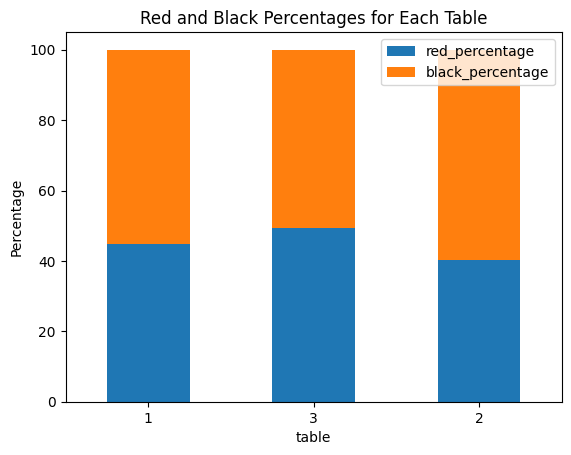

ERROR:root:KeyboardInterrupt while sending command.                 (0 + 0) / 4]
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

while True:

    df = spark.sql(
        """
        SELECT window, table, red_percentage, black_percentage FROM roulette_dashboard 
        WHERE window = (select max(window) from roulette_dashboard)
        """).toPandas()
    
    df.set_index('table', inplace=True)
    
    # Plot the bar graph
    ax = df.plot(kind='bar', stacked=True)
    ax.set_ylabel('Percentage')
    ax.set_title('Red and Black Percentages for Each Table')
    plt.xticks(rotation=0)  # Rotate x-axis labels if needed

    clear_output(wait=True)
    plt.show()

    sleep(1)

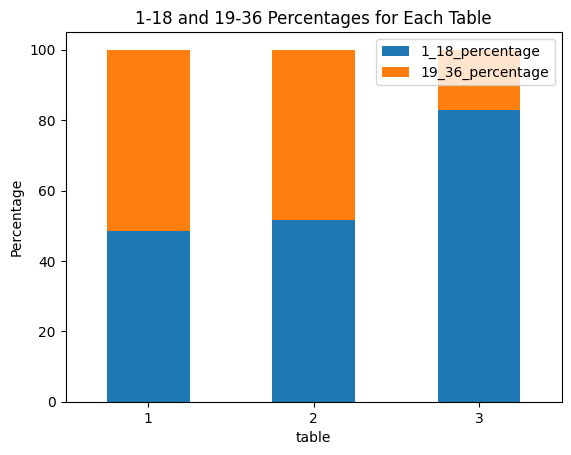

ERROR:root:KeyboardInterrupt while sending command.>                (0 + 0) / 2]
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

while True:

    df = spark.sql(
        """
        SELECT window, table, 1_18_percentage, 19_36_percentage FROM roulette_dashboard 
        WHERE window = (select max(window) from roulette_dashboard)
        ORDER BY table
        """).toPandas()
    
    df.set_index('table', inplace=True)
    
    # Plot the bar graph
    ax = df.plot(kind='bar', stacked=True)
    ax.set_ylabel('Percentage')
    ax.set_title('1-18 and 19-36 Percentages for Each Table')
    plt.xticks(rotation=0)  # Rotate x-axis labels if needed

    clear_output(wait=True)
    plt.show()

    sleep(1)

In [11]:
query.stop()

25/01/27 15:25:56 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 21, writer: org.apache.spark.sql.execution.streaming.sources.MemoryStreamingWrite@389c4d01] is aborting.
25/01/27 15:25:56 ERROR WriteToDataSourceV2Exec: Data source write support MicroBatchWrite[epoch: 21, writer: org.apache.spark.sql.execution.streaming.sources.MemoryStreamingWrite@389c4d01] aborted.
25/01/27 15:25:56 WARN TaskSetManager: Lost task 87.0 in stage 105.0 (TID 4448) (172.29.16.103 executor 0): TaskKilled (Stage cancelled: Job 67 cancelled part of cancelled job group 16c416e9-4412-468d-979a-988c3076c13e)
25/01/27 15:25:56 WARN TaskSetManager: Lost task 99.0 in stage 105.0 (TID 4449) (172.29.16.108 executor 1): TaskKilled (Stage cancelled: Job 67 cancelled part of cancelled job group 16c416e9-4412-468d-979a-988c3076c13e)
25/01/27 15:25:56 WARN TaskSetManager: Lost task 90.0 in stage 105.0 (TID 4450) (172.29.16.103 executor 0): TaskKilled (Stage cancelled: Job 67 cancelled part

In [12]:
spark.stop()

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)
